In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

In [2]:
char_inpatient = pd.read_csv('Medicare_Charge_Inpatient_DRG100_DRG_Summary_by_DRG_FY2011.csv')
char_outpatient = pd.read_csv('Medicare_Charge_Outpatient_APC30_Summary_by_APC_CY2011.csv')
pro_inpatient = pd.read_csv('Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv')
pro_outpatient = pd.read_csv('Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv')
history = pd.read_csv('Patient_history_samp.csv')
rev_history = pd.read_csv('Review_patient_history_samp.csv')
rev_transaction = pd.read_csv('Rreview_transaction_coo.csv')
transaction = pd.read_csv('Transaction_coo.csv')

#### Part 1: Identify providers that overcharge for certaing procedures or regions where procedures are too expensive.

##### Part1A: Highest Cost Variation

#### For In-patients

In [3]:
inp_max = pro_inpatient.loc[pro_inpatient.groupby(['DRG Definition','Provider State'])['Average Medicare Payments'].idxmax()].reset_index(drop=True)
inp_min = pro_inpatient.loc[pro_inpatient.groupby(['DRG Definition','Provider State'])['Average Medicare Payments'].idxmin()].reset_index(drop=True)

In [4]:
inp1=inp_max.copy()
inp1['Variation'] = inp_max['Average Medicare Payments'] - inp_min['Average Medicare Payments']
inp1 = inp1.loc[inp1.groupby(['DRG Definition'])['Variation'].idxmax()]
inp1.sort_values(by = 'Variation', ascending = False).head(3)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Variation
1053,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,11,929118.9091,156158.1818,154620.8182,128892.13820
3330,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,CROWN POINT,IN,46307,IN - Gary,14,225729.1429,131187.3571,130466.5714,113128.73807
4606,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,330234,WESTCHESTER MEDICAL CENTER,100 WOODS RD,VALHALLA,NY,10595,NY - White Plains,15,517381.3333,140255.2667,133177.2667,106932.68775


###### For In-patients procedures with the highest cost variation are following: 
###### 207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS
###### 460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC
###### 853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC 

#### For Out-patients

In [5]:
out_max = pro_outpatient.loc[pro_outpatient.groupby(['APC','Provider State'])['Average Total Payments'].idxmax()].reset_index(drop=True)
out_min = pro_outpatient.loc[pro_outpatient.groupby(['APC','Provider State'])['Average Total Payments'].idxmin()].reset_index(drop=True)

In [6]:
out1=out_max.copy()
out1['Variation']=out_max['Average Total Payments']-out_min['Average Total Payments']
out1 = out1.loc[out1.groupby(['APC'])['Variation'].idxmax()]
out1.sort_values(by = 'Variation', ascending = False).head(3)

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,Variation
277,0074 - Level IV Endoscopy Upper Airway,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,190,7764.569632,2062.470526,791.885526
559,0207 - Level III Nerve Injections,50153,O'CONNOR HOSPITAL,2105 FOREST AVENUE,SAN JOSE,CA,95128,CA - San Jose,68,5817.279412,712.091765,457.210856
892,0336 - Magnetic Resonance Imaging and Magnetic...,390133,LEHIGH VALLEY HOSPITAL,PO BOX 689,ALLENTOWN,PA,18105,PA - Allentown,99,3736.049192,680.095556,381.127980


###### For In-patients following Top 3 providers have the highest cost variation: 
###### 0074 - Level IV Endoscopy Upper Airway
###### 0207 - Level III Nerve Injections
###### 0336 - Magnetic Resonance Imaging and Magnetic Resonance Angiography without Contrast

#### PART 1B: Highest-Cost Claims by Provider - In-patients

In [7]:
cost_claim = pro_inpatient.loc[pro_inpatient.groupby(['DRG Definition','Provider Id'])['Average Medicare Payments'].idxmax()].reset_index(drop=True)
highest_cost_claim = cost_claim.loc[cost_claim.groupby(['DRG Definition'])['Average Medicare Payments'].idxmax()].head()
highest_cost_claim

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
456,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,210029,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,4940 EASTERN AVENUE,BALTIMORE,MD,21224,MD - Baltimore,11,17955.63636,16878.45455,15855.18182
1554,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,83,26402.79518,24865.61446,22873.49398
2986,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,64,54052.21875,50882.40625,48632.28125
4156,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50228,SAN FRANCISCO GENERAL HOSPITAL,1001 POTRERO AVENUE,SAN FRANCISCO,CA,94110,CA - San Francisco,19,111618.15790,24352.05263,23402.26316
6365,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50228,SAN FRANCISCO GENERAL HOSPITAL,1001 POTRERO AVENUE,SAN FRANCISCO,CA,94110,CA - San Francisco,34,77093.05882,14744.05882,13710.23529


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4C7163BC8>],
      dtype=object)

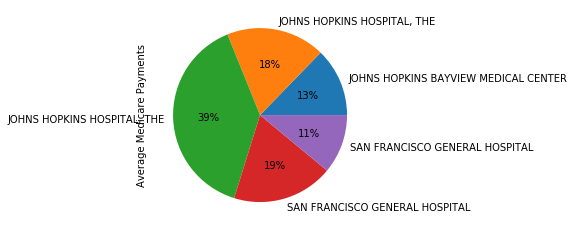

In [8]:
highest_cost_claim['Average Medicare Payments'].plot(kind='pie', 
            labels=highest_cost_claim["Provider Name"],
            autopct='%1.0f%%', # to get percentage and round off appropriately
            fontsize=10, 
            subplots='true')

#### For In-patients Highest-Cost Claims are by JOHNS HOPKINS BAYVIEW MEDICAL CENTER (38%) and SAN FRANCISCO GENERAL HOSPITAL (19%).

#### Part1B: Highest-Cost Claims by Provider - Out-patients

In [9]:
cost_claim1 = pro_outpatient.loc[pro_outpatient.groupby(['APC','Provider Id'])['Average Total Payments'].idxmax()].reset_index(drop=True)
highest_cost_claim1 = cost_claim1.loc[cost_claim1.groupby(['APC'])['Average Total Payments'].idxmax()].head()
highest_cost_claim1

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
1,0012 - Level I Debridement & Destruction,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,AK - Anchorage,994,149.589749,36.623853
424,0013 - Level II Debridement & Destruction,50334,SALINAS VALLEY MEMORIAL HOSPITAL,450 EAST ROMIE LANE,SALINAS,CA,93901,CA - Salinas,20,235.417500,85.930000
1874,0015 - Level III Debridement & Destruction,50153,O'CONNOR HOSPITAL,2105 FOREST AVENUE,SAN JOSE,CA,95128,CA - San Jose,329,685.188450,142.186505
3322,0019 - Level I Excision/ Biopsy,50002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,CA - Alameda County,16,8766.475000,470.720000
3837,0020 - Level II Excision/ Biopsy,50153,O'CONNOR HOSPITAL,2105 FOREST AVENUE,SAN JOSE,CA,95128,CA - San Jose,96,3418.156250,808.850000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4C5A9B248>],
      dtype=object)

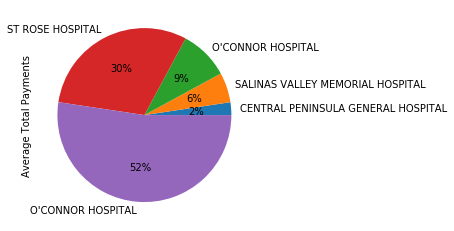

In [10]:
highest_cost_claim1['Average Total Payments'].plot(kind='pie', 
            labels=highest_cost_claim1["Provider Name"],
            autopct='%1.0f%%', # to get percentage and round off appropriately
            fontsize=10, 
            subplots='true')

#### For Out-patients Highest-Cost Claims are by O'CONNOR HOSPITAL (52%) and ST ROSE HOSPITAL (30%).

#### Part1C: Highest-Cost Claims by Region - Inpatient


In [11]:
cost_claim2 = pro_inpatient.loc[pro_inpatient.groupby(['DRG Definition','Provider State'])['Average Medicare Payments'].idxmax()].reset_index(drop=True)
highest_cost_claim2 = cost_claim2.loc[cost_claim2.groupby(['DRG Definition'])['Average Medicare Payments'].idxmax()].head()
highest_cost_claim2

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
20,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,210029,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,4940 EASTERN AVENUE,BALTIMORE,MD,21224,MD - Baltimore,11,17955.63636,16878.45455,15855.18182
71,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,83,26402.79518,24865.61446,22873.49398
122,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,64,54052.21875,50882.40625,48632.28125
157,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50228,SAN FRANCISCO GENERAL HOSPITAL,1001 POTRERO AVENUE,SAN FRANCISCO,CA,94110,CA - San Francisco,19,111618.15790,24352.05263,23402.26316
208,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50228,SAN FRANCISCO GENERAL HOSPITAL,1001 POTRERO AVENUE,SAN FRANCISCO,CA,94110,CA - San Francisco,34,77093.05882,14744.05882,13710.23529


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4C50977C8>],
      dtype=object)

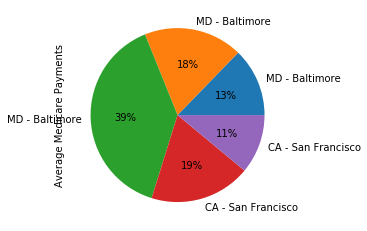

In [12]:
highest_cost_claim2['Average Medicare Payments'].plot(kind='pie', 
            labels=highest_cost_claim2["Hospital Referral Region (HRR) Description"],
            autopct='%1.0f%%', # to get percentage and round off appropriately
            fontsize=10, 
            subplots='true')

#### For In-patients, MD - Baltimore and CA - San Francisco are the regions with highest Cost claims.

#### Part1C: Highest-Cost Claims by Region - Outpatient

In [13]:
cost_claim3 = pro_outpatient.loc[pro_outpatient.groupby(['APC','Provider State'])['Average Total Payments'].idxmax()].reset_index(drop=True)
highest_cost_claim3 = cost_claim3.loc[cost_claim3.groupby(['APC'])['Average Total Payments'].idxmax()].head()
highest_cost_claim3

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
0,0012 - Level I Debridement & Destruction,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,AK - Anchorage,994,149.589749,36.623853
51,0013 - Level II Debridement & Destruction,50334,SALINAS VALLEY MEMORIAL HOSPITAL,450 EAST ROMIE LANE,SALINAS,CA,93901,CA - Salinas,20,235.417500,85.930000
101,0015 - Level III Debridement & Destruction,50153,O'CONNOR HOSPITAL,2105 FOREST AVENUE,SAN JOSE,CA,95128,CA - San Jose,329,685.188450,142.186505
150,0019 - Level I Excision/ Biopsy,50002,ST ROSE HOSPITAL,27200 CALAROGA AVE,HAYWARD,CA,94545,CA - Alameda County,16,8766.475000,470.720000
194,0020 - Level II Excision/ Biopsy,50153,O'CONNOR HOSPITAL,2105 FOREST AVENUE,SAN JOSE,CA,95128,CA - San Jose,96,3418.156250,808.850000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4C5747348>],
      dtype=object)

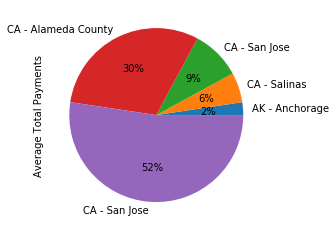

In [14]:
highest_cost_claim3['Average Total Payments'].plot(kind='pie', 
            labels=highest_cost_claim3["Hospital Referral Region (HRR) Description"],
            autopct='%1.0f%%', # to get percentage and round off appropriately
            fontsize=10, 
            subplots='true')

#### For Out-patients, CA - San Jose and CA - Alameda County are the regions with highest Cost claims.

#### Part1D: Highest Number of Procedures and Largest Differences between Claims and Reimbursements - inpatient

In [15]:
pro_inpatient['proc'] = (pro_inpatient['Average Total Payments'] - pro_inpatient['Average Medicare Payments']) / pro_inpatient['Total Discharges']
max_diff = pro_inpatient.loc[pro_inpatient.groupby(['DRG Definition','Provider State'])['proc'].idxmax()].reset_index(drop=True)
max_diff.loc[max_diff.groupby(['DRG Definition'])['proc'].idxmax()].head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,proc
14,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,140008,LOYOLA GOTTLIEB MEMORIAL HOSPITAL,701 WEST NORTH AVE,MELROSE PARK,IL,60160,IL - Melrose Park,16,56027.00000,18420.562500,4401.875000,876.167969
66,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,150158,IU HEALTH WEST HOSPITAL,1111 N RONALD REAGAN PKWY,AVON,IN,46123,IN - Indianapolis,13,18670.07692,7398.153846,3304.461538,314.899408
116,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,140150,UNIVERSITY OF ILLINOIS HOSPITAL,1740 WEST TAYLOR ST SUITE 1400,CHICAGO,IL,60612,IL - Chicago,16,83504.31250,38370.000000,22039.375000,1020.664062
164,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,120011,KAISER FOUNDATION HOSPITAL,3288 MOANALUA RD,HONOLULU,HI,96819,HI - Honolulu,12,25010.91667,21032.083330,4109.250000,1410.236111
235,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,310006,"ST MARY'S HOSPITAL, PASSAIC",350 BOULEVARD,PASSAIC,NJ,7055,NJ - Hackensack,11,40431.72727,9945.636364,5129.000000,437.876033


#### The three providers who have the highest number of procedures with the largest difference between their claimed charges to patients and their reimbursement from Medicare are KAISER FOUNDATION HOSPITAL, UNIVERSITY OF ILLINOIS HOSPITAL and LOYOLA GOTTLIEB MEMORIAL HOSPITAL.

#### Part1D: Highest Number of Procedures and Largest Differences between Claims and Reimbursements - outpatient

In [16]:
pro_outpatient['proc'] = (pro_outpatient['Average  Estimated Submitted Charges'] - pro_outpatient['Average Total Payments']) / pro_outpatient['Outpatient Services']
max_diff1 = pro_outpatient.loc[pro_outpatient.groupby(['APC','Provider State'])['proc'].idxmax()].reset_index(drop=True)
max_diff1.loc[max_diff1.groupby(['APC'])['proc'].idxmax()].head()

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,proc
27,0012 - Level I Debridement & Destruction,280129,NEBRASKA ORTHOPAEDIC HOSPITAL,2808 SOUTH 143RD PLZ,OMAHA,NE,68144,NE - Omaha,15,841.900000,14.460000,55.162667
48,0013 - Level II Debridement & Destruction,10158,RUSSELLVILLE HOSPITAL,15155 HIGHWAY 43,RUSSELLVILLE,AL,35653,AL - Birmingham,13,5231.000000,55.600000,398.107692
118,0015 - Level III Debridement & Destruction,230176,OAKWOOD SOUTHSHORE MEDICAL CENTER,5450 FORT STREET,TRENTON,MI,48183,MI - Dearborn,11,2661.200909,93.882727,233.392562
150,0019 - Level I Excision/ Biopsy,50739,CENTINELA HOSPITAL MEDICAL CENTER,555 EAST HARDY STREET,INGLEWOOD,CA,90301,CA - Los Angeles,12,26466.645000,392.840000,2172.817083
234,0020 - Level II Excision/ Biopsy,490112,CJW MEDICAL CENTER,1401 JOHNSTON WILLIS DRIVE,RICHMOND,VA,23235,VA - Richmond,11,15427.479090,567.060000,1350.947190


#### The three providers who have the highest number of procedures with the largest difference between their claimed charges to patients and their reimbursement from Medicare are CENTINELA HOSPITAL MEDICAL CENTER, CJW MEDICAL CENTER and RUSSELLVILLE HOSPITAL.

#### Part2: Identify the three providers that are least similar to other providers and the three regions that are least similar to other regions.

#### Part2A: Providers Least Like Others - inpatient


In [17]:
part2a_in = pro_inpatient[['Provider Id', 'Average Medicare Payments']].groupby('Provider Id').mean().reset_index()

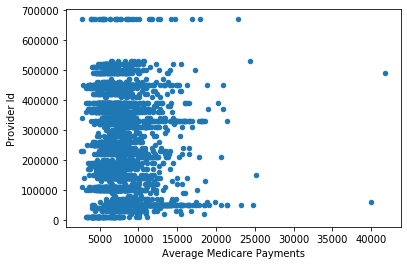

In [18]:
part2a_in.plot(kind = 'scatter', y = 'Provider Id', x = 'Average Medicare Payments')
plt.show()

In [19]:
Q1a = part2a_in['Average Medicare Payments'].quantile(0.25)
Q3a = part2a_in['Average Medicare Payments'].quantile(0.75)
IQRa = Q3a - Q1a
print(IQRa)

3206.8280313745836


In [20]:
a = part2a_in [ (part2a_in['Average Medicare Payments'] < (Q1a - 1.5 * IQRa)) | (part2a_in['Average Medicare Payments'] > (Q3a + 1.5 * IQRa))].sort_values(by = 'Average Medicare Payments', ascending = False).head(3)

In [21]:
print(a)

      Provider Id  Average Medicare Payments
3143       490142               41836.888890
540         60096               39943.173080
1102       150166               25098.255195


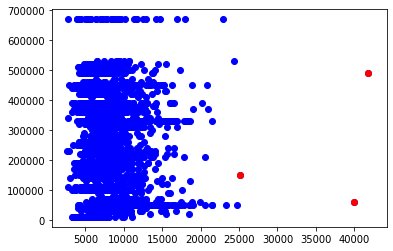

In [22]:
plt.scatter(y = part2a_in['Provider Id'], x = part2a_in['Average Medicare Payments'] ,facecolors='blue')
plt.scatter(a['Average Medicare Payments'], a['Provider Id'],color="red")
plt.show()

#### 3 Providers Least Like Others - inpatient are 490142, 60096, 150166.

#### Part2A: Providers Least Like Others - Outpatient

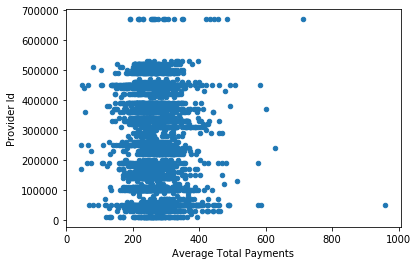

In [23]:
part2a_out = pro_outpatient[['Provider Id', 'Average Total Payments']].groupby('Provider Id').mean().reset_index()
part2a_out.plot(kind = 'scatter', y = 'Provider Id', x = 'Average Total Payments')
plt.show()

In [24]:
Q1b = part2a_out['Average Total Payments'].quantile(0.25)
Q3b = part2a_out['Average Total Payments'].quantile(0.75)
IQRb = Q3b - Q1b
print(IQRb)

69.58679011639651


In [25]:
b = part2a_out [(part2a_out['Average Total Payments'] < (Q1b - 1.5 * IQRb)) | (part2a_out['Average Total Payments'] > (Q3b + 1.5 * IQRb))].sort_values('Average Total Payments', ascending = False).head(3)
print(b)

      Provider Id  Average Total Payments
432         50714              960.595632
3134       670061              712.396480
1474       240069              629.085289


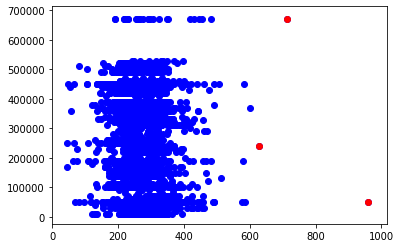

In [26]:
plt.scatter(y = part2a_out['Provider Id'], x = part2a_out['Average Total Payments'] ,facecolors='blue')
plt.scatter(b['Average Total Payments'], b['Provider Id'],color="red")
plt.show()

####  3 Providers Least Like Others - inpatient are 50714, 670061, 240069.

#### Part2B: Regions Least Like Others - inpatient

In [27]:
part2b_in = pro_inpatient[['Provider State', 'Provider City', 'Average Medicare Payments']].groupby(['Provider City', 'Provider State']).mean().reset_index()

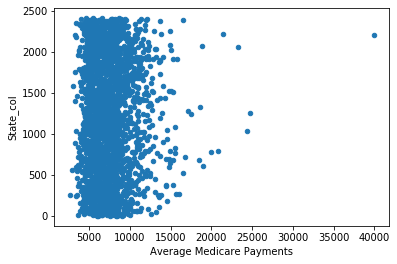

In [28]:
part2b_in['State_col'] = part2b_in.index
part2b_in.plot(kind = 'scatter', y = 'State_col', x = 'Average Medicare Payments')
plt.show()

In [29]:
Q1c = part2b_in['Average Medicare Payments'].quantile(0.25)
Q3c = part2b_in['Average Medicare Payments'].quantile(0.75)
IQRc = Q3c - Q1c
print(IQRc)

2759.422688730803


In [30]:
a1 = part2b_in [(part2b_in['Average Medicare Payments'] < (Q1c - 1.5 * IQRc)) | (part2b_in['Average Medicare Payments'] > (Q3c + 1.5 * IQRc))].sort_values('Average Medicare Payments', ascending = False).head(3)
print(a1)

     Provider City Provider State  Average Medicare Payments  State_col
2211          VAIL             CO               39943.173080       2211
1257     LOS BANOS             CA               24755.286045       1257
1038       JACKSON             WY               24350.493057       1038


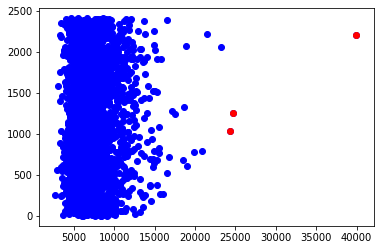

In [31]:
plt.scatter(y = part2b_in['State_col'], x = part2b_in['Average Medicare Payments'] ,facecolors='blue')
plt.scatter(a1['Average Medicare Payments'], a1['State_col'],color="red")
plt.show()

#### 3 Regions Least Like Others - inpatient - are Vail, CO; Los Banos, DC and Jackson, WY.

#### Part2B: Regions Least Like Others - outpatient

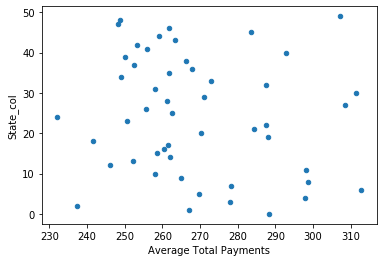

In [32]:
part2b_out = pro_outpatient[['Provider State','Average Total Payments']].groupby('Provider State').mean().reset_index()

part2b_out['State_col'] = part2b_out.index
part2b_out.plot(kind = 'scatter', y = 'State_col', x = 'Average Total Payments')

In [33]:
Q1d = part2b_out['Average Total Payments'].quantile(0.25)
Q3d = part2b_out['Average Total Payments'].quantile(0.75)
IQRd = Q3d - Q1d
print(IQRd)

28.30917453857643


In [34]:
b1 = part2b_out [(part2b_out['Average Total Payments'] < (Q1d - 1.5 * IQRd)) | (part2b_out['Average Total Payments'] > (Q3d + 1.5 * IQRd))].sort_values('Average Total Payments', ascending = False).head(3)
print(b1)

Empty DataFrame
Columns: [Provider State, Average Total Payments, State_col]
Index: []


In [35]:
part2b_out['Average Total Payments'].mean()

269.11016711746424

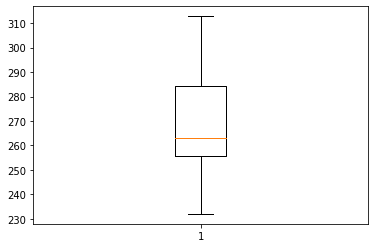

In [36]:
plt.boxplot(part2b_out['Average Total Payments'])
plt.show()

#### For Outpatients - data is evenly distributed - Total payments in all regions is similar.

### Part 3: Identify 10,000 Medicare patients who are involved in anamalous activities.

In [37]:
history.head()

,id,age,gender,income
0,306535165,65-74,F,24000-31999
1,742231134,65-74,F,48000+
2,928807201,75-84,M,24000-31999
3,83686538,<65,F,32000-47999
4,755607449,65-74,F,48000+


In [38]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      500000 non-null  int64 
 1   age     497470 non-null  object
 2   gender  500000 non-null  object
 3   income  497469 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [39]:
rev_history.head()

,id,age,gender,income
0,381693273,65-74,F,24000-31999
1,444060924,65-74,M,24000-31999
2,3641691,65-74,F,24000-31999
3,672653795,65-74,M,48000+
4,144916176,<65,F,48000+


In [40]:
rev_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5000 non-null   int64 
 1   age     4974 non-null   object
 2   gender  5000 non-null   object
 3   income  4974 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [41]:
transaction.head()

,id,global_proc_id,count
0,159125,1,1
1,191852,1,1
2,321083,1,1
3,383037,1,1
4,467729,1,1


In [42]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514809 entries, 0 to 1514808
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   id              1514809 non-null  int64
 1   global_proc_id  1514809 non-null  int64
 2   count           1514809 non-null  int64
dtypes: int64(3)
memory usage: 34.7 MB


In [43]:
rev_transaction.head()

,id,global_proc_id,count
0,65822,109,1
1,65822,125,1
2,119695,70,1
3,119695,124,1
4,119695,125,1


In [44]:
rev_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15041 entries, 0 to 15040
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              15041 non-null  int64
 1   global_proc_id  15041 non-null  int64
 2   count           15041 non-null  int64
dtypes: int64(3)
memory usage: 352.6 KB


### Data preparation

##### Handling missing values

In [45]:
history.dropna(inplace = True)
history.isna().sum()

id        0
age       0
gender    0
income    0
dtype: int64

In [46]:
transaction.dropna(inplace = True)
transaction.isna().sum()

id                0
global_proc_id    0
count             0
dtype: int64

In [47]:
rev_history.dropna(inplace = True)
rev_history.isna().sum()

id        0
age       0
gender    0
income    0
dtype: int64

In [48]:
rev_transaction.dropna(inplace = True)
rev_transaction.isna().sum()

id                0
global_proc_id    0
count             0
dtype: int64

In [49]:
patient_trans=pd.merge(transaction,history,
              left_on='id',right_on='id',
                    how='inner')

In [67]:
patient_trans1=pd.merge(transaction,history,
              left_on='id',right_on='id',
                    how='inner')

In [50]:
patient_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484652 entries, 0 to 1484651
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1484652 non-null  int64 
 1   global_proc_id  1484652 non-null  int64 
 2   count           1484652 non-null  int64 
 3   age             1484652 non-null  object
 4   gender          1484652 non-null  object
 5   income          1484652 non-null  object
dtypes: int64(3), object(3)
memory usage: 79.3+ MB


In [51]:
#Creating dummy variables 
columns=['age','gender','income']
for i in columns:
    dummy = pd.get_dummies(patient_trans[i], prefix=i)
    patient_trans = pd.concat([patient_trans, dummy], axis=1)
    patient_trans.drop(i,axis=1,inplace=True)

In [52]:
patient_trans

,id,global_proc_id,count,age_65-74,age_75-84,age_85+,age_<65,gender_F,gender_M,income_16000-23999,income_24000-31999,income_32000-47999,income_48000+,income_<16000
0,159125,1,1,0,1,0,0,1,0,1,0,0,0,0
1,159125,17,1,0,1,0,0,1,0,1,0,0,0,0
2,159125,19,1,0,1,0,0,1,0,1,0,0,0,0
3,159125,26,1,0,1,0,0,1,0,1,0,0,0,0
4,159125,34,1,0,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484647,973537121,130,1,1,0,0,0,1,0,0,0,1,0,0
1484648,984838944,130,1,1,0,0,0,0,1,0,0,0,1,0
1484649,987582418,130,1,0,0,1,0,1,0,0,1,0,0,0
1484650,991584732,130,1,1,0,0,0,0,1,0,1,0,0,0


In [53]:
patient_trans_scaled = StandardScaler().fit_transform(patient_trans)
patient_trans_scaled

array([[-1.73305721, -1.19684419,  0.        , ..., -0.48764214,
        -0.55163387, -0.5253021 ],
       [-1.73305721, -0.68038634,  0.        , ..., -0.48764214,
        -0.55163387, -0.5253021 ],
       [-1.73305721, -0.61582911,  0.        , ..., -0.48764214,
        -0.55163387, -0.5253021 ],
       ...,
       [ 1.69052334,  2.96709722,  0.        , ..., -0.48764214,
        -0.55163387, -0.5253021 ],
       [ 1.7044001 ,  2.96709722,  0.        , ..., -0.48764214,
        -0.55163387, -0.5253021 ],
       [ 1.7102373 ,  2.96709722,  0.        , ..., -0.48764214,
         1.81279659, -0.5253021 ]])

In [54]:
patient_trans_new = pd.DataFrame(patient_trans_scaled)
patient_trans_new.columns = patient_trans.columns
patient_trans_new.index = patient_trans.index

In [55]:
patient_trans_new.head()

,id,global_proc_id,count,age_65-74,age_75-84,age_85+,age_<65,gender_F,gender_M,income_16000-23999,income_24000-31999,income_32000-47999,income_48000+,income_<16000
0,-1.733057,-1.196844,0.0,-0.889256,1.690204,-0.385616,-0.452062,0.906024,-0.906024,1.96432,-0.424186,-0.487642,-0.551634,-0.525302
1,-1.733057,-0.680386,0.0,-0.889256,1.690204,-0.385616,-0.452062,0.906024,-0.906024,1.96432,-0.424186,-0.487642,-0.551634,-0.525302
2,-1.733057,-0.615829,0.0,-0.889256,1.690204,-0.385616,-0.452062,0.906024,-0.906024,1.96432,-0.424186,-0.487642,-0.551634,-0.525302
3,-1.733057,-0.389879,0.0,-0.889256,1.690204,-0.385616,-0.452062,0.906024,-0.906024,1.96432,-0.424186,-0.487642,-0.551634,-0.525302
4,-1.733057,-0.131650,0.0,-0.889256,1.690204,-0.385616,-0.452062,0.906024,-0.906024,1.96432,-0.424186,-0.487642,-0.551634,-0.525302


In [56]:
LOF1 = LocalOutlierFactor(n_neighbors = 50, n_jobs = -1, contamination = 0.002)

In [57]:
medicare_patient = LOF1.fit_predict(patient_trans_new)

In [58]:
label = pd.DataFrame(medicare_patient)
label.index = patient_trans_new.index
label.columns = ['label']

In [65]:
label.label.value_counts()

 1    1481682
-1       2970
Name: label, dtype: int64

In [68]:
medicare_patients = patient_trans1[label['label']==-1]

In [70]:
del medicare_patients['count']

### Patients that are involved in Anamalous activites

In [80]:
medicare_patients

,id,global_proc_id,age,gender,income
224,4009080,31,<65,F,16000-23999
297,5330645,31,<65,M,48000+
328,5731044,30,85+,M,16000-23999
383,6611442,29,65-74,M,16000-23999
519,8313961,32,85+,M,48000+
...,...,...,...,...,...
1445080,982003005,31,85+,M,24000-31999
1445087,985359451,31,<65,F,32000-47999
1445090,994464980,31,85+,F,32000-47999
1445096,999086565,31,<65,F,24000-31999
